In [1]:
#@markdown ### **Imports**
# diffusion policy import
from typing import Tuple, Sequence, Dict, Union, Optional
import numpy as np
import math
import torch
import torch.nn as nn
import collections
import zarr
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm

# env import
import gym
from gym import spaces
import pygame
import pymunk
import pymunk.pygame_util
from pymunk.space_debug_draw_options import SpaceDebugColor
from pymunk.vec2d import Vec2d
import shapely.geometry as sg
import cv2
import skimage.transform as st
from skvideo.io import vwrite
from IPython.display import Video
import gdown
import os

/home/zihao/anaconda3/envs/diff/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from network import ConditionalUnet1D

In [3]:
from dataset import *

dataset = get_dataloader()
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    num_workers=1,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=True
)

In [4]:
#@markdown ### **Network Demo**
obs_horizon = 0
pred_horizon = 16


# obs_horizon = 2
# pred_horizon = 16
#


# observation and action dimensions corrsponding to
# the output of PushTEnv
obs_dim = 0
action_dim = 1

# create network object
noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon
)

# example inputs
noised_action = torch.randn((1, pred_horizon, action_dim))
obs = torch.zeros((1, obs_horizon, obs_dim))
diffusion_iter = torch.zeros((1,))

# the noise prediction network
# takes noisy action, diffusion iteration and observation as input
# predicts the noise added to action
noise = noise_pred_net(
    sample=noised_action,
    timestep=diffusion_iter,
    global_cond=obs.flatten(start_dim=1))

number of parameters: 6.520806e+07


In [5]:
print(noised_action.shape)
print(diffusion_iter.shape)
print(obs.flatten(start_dim=1).shape)

torch.Size([1, 16, 1])
torch.Size([1])
torch.Size([1, 0])


In [6]:
# illustration of removing noise
# the actual noise removal is performed by NoiseScheduler
# and is dependent on the diffusion noise schedule
denoised_action = noised_action - noise

# for this demo, we use DDPMScheduler with 100 diffusion iterations
num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)

# device transfer
device = torch.device('cuda')
_ = noise_pred_net.to(device)

In [7]:
num_epochs = 100

# Exponential Moving Average
# accelerates training and improves stability
# holds a copy of the model weights
ema = EMAModel(
    parameters=noise_pred_net.parameters(),
    power=0.75)

# Standard ADAM optimizer
# Note that EMA parametesr are not optimized
optimizer = torch.optim.AdamW(
    params=noise_pred_net.parameters(),
    lr=1e-4, weight_decay=1e-6)

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(dataloader) * num_epochs
)

In [9]:
with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    # epoch loop
    for epoch_idx in tglobal:
        epoch_loss = list()
        # batch loop
        with tqdm(dataloader, desc='Batch', leave=False) as tepoch:
            for nbatch in tepoch:
                # data normalized in dataset
                # device transfer
                # nobs = nbatch['obs'].to(device)
                # naction = nbatch['action'].to(device)
                # B = nobs.shape[0]

                naction = nbatch.to(device)
                B = naction.shape[0]

                # observation as FiLM conditioning
                # (B, obs_horizon, obs_dim)
                # obs_cond = nobs[:,:obs_horizon,:]
                # (B, obs_horizon * obs_dim)
                # obs_cond = obs_cond.flatten(start_dim=1)
                
                obss = torch.zeros((B, 0, 0)).to(device)
                obs_cond = obss.flatten(start_dim=1)

                # sample noise to add to actions
                noise = torch.randn(naction.shape, device=device)

                # sample a diffusion iteration for each data point
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps,
                    (B,), device=device
                ).long()

                # add noise to the clean images according to the noise magnitude at each diffusion iteration
                # (this is the forward diffusion process)
                noisy_actions = noise_scheduler.add_noise(
                    naction, noise, timesteps)

                # predict the noise residual
                noise_pred = noise_pred_net(
                    noisy_actions, timesteps, global_cond=obs_cond)

                # L2 loss
                loss = nn.functional.mse_loss(noise_pred, noise)

                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # step lr scheduler every batch
                # this is different from standard pytorch behavior
                lr_scheduler.step()

                # update Exponential Moving Average of the model weights
                ema.step(noise_pred_net.parameters())

                # logging
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)
        tglobal.set_postfix(loss=np.mean(epoch_loss))

# Weights of the EMA model
# is used for inference
ema_noise_pred_net = noise_pred_net
ema.copy_to(ema_noise_pred_net.parameters())

Epoch: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s, loss=0.0508]


In [96]:
patch_mean = 0.2

# inference actions
B = 1
obss = torch.zeros((B, 0, 0)).to(device)
obs_cond = obss.flatten(start_dim=1)

store = []

with torch.no_grad():
    naction = torch.randn(
        (B, pred_horizon, action_dim), device=device)
    
    # init scheduler
    noise_scheduler.set_timesteps(num_diffusion_iters)

    for k in noise_scheduler.timesteps:
        # predict noise
        noise_pred = ema_noise_pred_net(
            sample=naction,
            timestep=k,
            global_cond=obs_cond
        )

        # apply a patch
        naction[:,4:10,:] = patch_mean

        # inverse diffusion step (remove noise)
        naction = noise_scheduler.step(
            model_output=noise_pred,
            timestep=k,
            sample=naction
        ).prev_sample

        store.append(naction.detach().to('cpu').numpy().squeeze())

    naction = naction.detach().to('cpu').numpy()

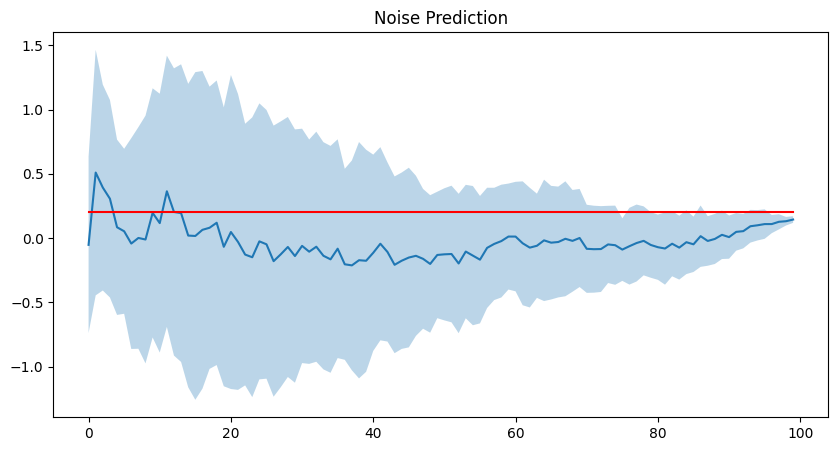

In [97]:

import matplotlib.pyplot as plt

data = np.array(store).squeeze()

mean = np.mean(data, axis=1)
std = np.std(data, axis=1)

plt.figure(figsize=(10,5))
plt.plot(mean, label='mean')
plt.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha=0.3)
plt.plot(np.arange(len(mean)), np.ones_like(mean)*patch_mean, label='patch', color='r')
plt.title('Noise Prediction')
plt.show()
